In [1]:
from ipycanvas import Canvas
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
puzzle = [
    [1, 2, 3, 4],
    [5, 6, 7, 8],
    [9, 10, 11, 12],
    [13, 14, 15, 0]
]

puzzle = np.array(puzzle)

In [3]:
canvas_width = 400
canvas_height = 400

tile_width = canvas_width / 4
tile_height = canvas_height / 4

canvas = Canvas(width = canvas_width, height = canvas_height, sync_image_data=True)

In [4]:
def draw_puzzle(puzzle):
    canvas.clear()
    for y in range(4):
        for x in range(4):
            canvas.stroke_rect(x * tile_width, y * tile_height, tile_width, tile_height)
            
            if puzzle[y, x] != 0:
                canvas.stroke_text(str(puzzle[y, x]), int((x + 0.5) * tile_width), int((y + 0.5) * tile_height))

def draw_arrow(from_tile, to_tile):
    
    from_x = int((from_tile[0] + 0.5) * tile_width)
    from_y = int((from_tile[1] + 0.5) * tile_height)
    
    to_x = int((to_tile[0] + 0.5) * tile_width)
    to_y = int((to_tile[1] + 0.5) * tile_height)
    
    dist = to_tile - from_tile
    
    dist_offset = 20
    to_x -= int(dist_offset * dist[0])
    to_y -= int(dist_offset * dist[1])
    
    canvas.stroke_style = "red"
    canvas.line_width = 2.0
    canvas.stroke_line(from_x, from_y, to_x, to_y)
    
    # draw tip of arrow
    angle = np.radians(90.0)
    tip_length = 10
    offset = np.sin(angle) * tip_length
    
    # up
    if (dist == np.array([0, -1])).all():
        canvas.stroke_line(to_x, to_y, to_x - offset, to_y + tip_length)
        canvas.stroke_line(to_x, to_y, to_x + offset, to_y + tip_length)
    
    # down
    elif (dist == np.array([0, +1])).all():
        canvas.stroke_line(to_x, to_y, to_x - offset, to_y - tip_length)
        canvas.stroke_line(to_x, to_y, to_x + offset, to_y - tip_length)
        
    # left
    elif (dist == np.array([-1, 0])).all():
        canvas.stroke_line(to_x, to_y, to_x + tip_length, to_y - offset)
        canvas.stroke_line(to_x, to_y, to_x + tip_length, to_y + offset)
        
    elif (dist == np.array([+1, 0])).all():
        canvas.stroke_line(to_x, to_y, to_x - tip_length, to_y - offset)
        canvas.stroke_line(to_x, to_y, to_x - tip_length, to_y + offset)
    
    canvas.stroke_style = "black"
    canvas.line_width = 1.0
    
def draw_puzzle_move(puzzle, move):
        draw_puzzle(puzzle)
        
        empty_pos = np.argwhere(puzzle == 0)[0]
        
        if move == "up":
            draw_arrow(empty_pos, (empty_pos[0], empty_pos[1] - 1))
            
        elif move == "down":
            draw_arrow(empty_pos, (empty_pos[0], empty_pos[1] + 1))
            
        elif move == "left":
            draw_arrow(empty_pos, (empty_pos[0] - 1, empty_pos[1]))
            
        elif move == "right":
            draw_arrow(empty_pos, (empty_pos[0] + 1, empty_pos[1]))

In [5]:
def show_canvas(canvas_title):
    # save drawing as numpy array and draw with matplotlib
    canvas_img = canvas.get_image_data()

    plt.title(canvas_title)
    plt.imshow(canvas_img)
    plt.axis("off")
    plt.show()

In [6]:
draw_puzzle(puzzle)

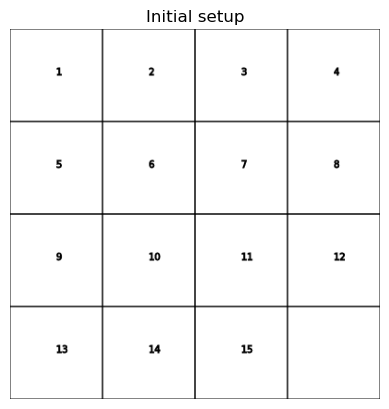

In [7]:
show_canvas("Initial setup")

In [8]:
def generate_move_sequence(length):
    return random.choices(["up", "down", "left", "right"], k = length)

In [9]:
def get_valid_moves(puzzle):
    valid_moves = []
    empty_tile = np.argwhere(puzzle == 0)[0]
    
    # oben noch platz
    if empty_tile[0] > 0:
        valid_moves.append("up")
        
    # unten noch platz
    if empty_tile[0] < 3:
        valid_moves.append("down")
        
    # links noch platz
    if empty_tile[1] > 0:
        valid_moves.append("left")
    
    # rechts noch platz
    if empty_tile[1] < 3:
        valid_moves.append("right")
        
    return valid_moves

In [10]:
def get_puzzle_after_move(puzzle, move):
    
    puzzle_copy = np.copy(puzzle)
    
    if move in get_valid_moves(puzzle):
        
        # first component is y, second is x
        empty_tile = np.argwhere(puzzle == 0)[0]
        neighbor_tile = None
        
        if move == "up":
            neighbor_tile = np.array([empty_tile[0] - 1, empty_tile[1]])
        elif move == "down":
            neighbor_tile = np.array([empty_tile[0] + 1, empty_tile[1]])
        elif move == "left":
            neighbor_tile = np.array([empty_tile[0], empty_tile[1] - 1])
        elif move == "right":
            neighbor_tile = np.array([empty_tile[0], empty_tile[1] + 1])
        
        tmp = puzzle_copy[neighbor_tile[0], neighbor_tile[1]]
        puzzle_copy[neighbor_tile[0], neighbor_tile[1]] = 0
        puzzle_copy[empty_tile[0], empty_tile[1]] = tmp

    return puzzle_copy

In [11]:
n_shuffles = 30

move_sequence = generate_move_sequence(n_shuffles)

for move in move_sequence:
    puzzle = get_puzzle_after_move(puzzle, move)

draw_puzzle(puzzle)

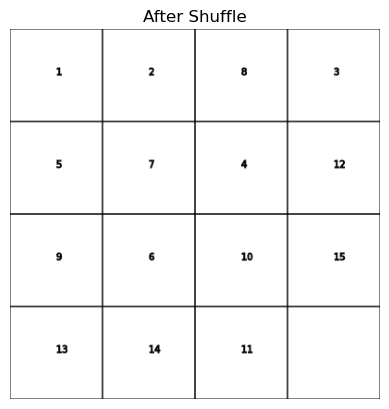

In [12]:
show_canvas("After Shuffle")

In [13]:
def is_solution(puzzle):
    counter = 1
    for y in range(4):
            for x in range(4):
                if y == 3 and x == 3:
                    return puzzle[y, x] == 0

                if puzzle[y, x] != counter:
                    break

                counter += 1
    return False

In [71]:

# implementiere einen bfs
def solve_BFS(puzzle):
    
    # statistics
    puzzles_generated_BFS = 0
    
    end_puzzle = puzzle if is_solution(puzzle) else None
    
    queue = [puzzle]
    from_move = {}
    from_move[str(puzzle)] = ("", None)
    
    # cache previous results to speed up process
    visited = {str(puzzle)}
    
    while len(queue) > 0 and end_puzzle is None:
        
        current = queue.pop(0)
        
        # generate all boards resulting from valid moves
        for move in get_valid_moves(current):
            
            resulting_puzzle = get_puzzle_after_move(current, move)
            puzzles_generated_BFS += 1
            
            if str(resulting_puzzle) in visited:
                continue
            
            from_move[str(resulting_puzzle)] = (move, current)
            
            # print(move)
            # print(resulting_puzzle)
            
            if is_solution(resulting_puzzle):
                end_puzzle = resulting_puzzle
                break
                
            queue.append(resulting_puzzle)
            
        visited.add(str(current))
    
    move_sequence = []
    puzzle_sequence = []
    
    if end_puzzle is not None:
        
        current = end_puzzle
        
        while current is not None:
            move, parent = from_move[str(current)]
            
            move_sequence.insert(0, move)
            puzzle_sequence.insert(0, current)
            
            current = parent
    
    return move_sequence, puzzle_sequence, puzzles_generated_BFS

In [75]:
import heapdict

def solve_Astar(puzzle, heuristic):
    
    # statistics
    puzzles_generated_Astar = 0
    
    h = heapdict.heapdict()
    
    # wichtig, damit ein node nicht wieder eingefügt wird, nachdem er aus dem heap entfernt wurde
    # aus dem heap entfernt werden = es kann niemals geringere kosten geben (da monoton steigend)
    explored_set = set()
    
    h[puzzle.tobytes()] = 0
    
    # ermöglicht traceback des richtigen paths
    # man muss move (erstes argument) und parent (ein puzzle string) speichern
    from_move = {}
    from_move[puzzle.tobytes()] = ("", None)
    
    end_puzzle_string = None 
    
    while h:
        
        (current_string, cost) = h.popitem()
        current = np.frombuffer(current_string, dtype=int).reshape((4,4))
        
        explored_set.add(current_string)
        
        #print(cost)
        #print(str(current))
        
        if is_solution(current):
            end_puzzle_string = current_string
            break
        
        for move in get_valid_moves(current):
            
            resulting_puzzle = get_puzzle_after_move(current, move)
            puzzles_generated_Astar += 1
            
            resulting_key = resulting_puzzle.tobytes()
            
            # braucht nicht mehr betrachtet werden, da kosten nur höher sein können
            # aber vergleich vielleicht nicht mehr da, da schon aus dem Heap gelöscht
            if resulting_key in explored_set:
                continue
            
            resulting_cost = cost + heuristic(resulting_puzzle)
            
            if resulting_key not in h or h[resulting_key] > resulting_cost:
                h[resulting_key] = resulting_cost
                
                # kostenreduktion oder neu eingefügt - parent muss gemerkt werden
                from_move[resulting_key] = (move, current_string)
    
    # hier findet der traceback stack
    move_sequence = []
    # keine strings sondern np arrays
    puzzle_sequence = []
    
    if end_puzzle_string is not None:
        
        current_string = end_puzzle_string

        while current_string is not None:

            current_move, parent_string = from_move[current_string]
            current_puzzle = np.frombuffer(current_string, dtype=int).reshape((4, 4))
            
            puzzle_sequence.insert(0, current_puzzle)
            move_sequence.insert(0, current_move)
            
            current_string = parent_string
        
        
    return move_sequence, puzzle_sequence, puzzles_generated_Astar

In [76]:
def displacement_heuristic(puzzle):
    
    num_displaced = 0
    
    counter = 1
    
    for y in range(4):
        for x in range(4):
            
            if x == 3 and y == 3 and puzzle[x, y] != 0:
                num_displaced += 1
            
            elif puzzle[y, x] != counter:
                num_displaced += 1
                
            counter += 1
                
    return num_displaced

In [77]:
move_sequence_BFS, puzzle_sequence_BFS, puzzles_generated_BFS = solve_BFS(puzzle)
move_sequence_Astar, puzzle_sequence_Astar, puzzles_generated_Astar = solve_Astar(puzzle, displacement_heuristic)

print(f"BFS #puzzles generated: {puzzles_generated_BFS}")
print(f"Astar #puzzles generated: {puzzles_generated_Astar}")

BFS #puzzles generated: 13536
Astar #puzzles generated: 1308


In [78]:
def print_solution(move_sequence, puzzle_sequence):
    
    for i, move in enumerate(move_sequence):
        if move != "":
            print("\nApply move: ", move, "\n")
        print(puzzle_sequence[i])

In [79]:
print_solution(move_sequence_Astar, puzzle_sequence_Astar)

[[ 1  2  8  3]
 [ 5  7  4 12]
 [ 9  6 10 15]
 [13 14 11  0]]

Apply move:  up 

[[ 1  2  8  3]
 [ 5  7  4 12]
 [ 9  6 10  0]
 [13 14 11 15]]

Apply move:  up 

[[ 1  2  8  3]
 [ 5  7  4  0]
 [ 9  6 10 12]
 [13 14 11 15]]

Apply move:  left 

[[ 1  2  8  3]
 [ 5  7  0  4]
 [ 9  6 10 12]
 [13 14 11 15]]

Apply move:  up 

[[ 1  2  0  3]
 [ 5  7  8  4]
 [ 9  6 10 12]
 [13 14 11 15]]

Apply move:  right 

[[ 1  2  3  0]
 [ 5  7  8  4]
 [ 9  6 10 12]
 [13 14 11 15]]

Apply move:  down 

[[ 1  2  3  4]
 [ 5  7  8  0]
 [ 9  6 10 12]
 [13 14 11 15]]

Apply move:  left 

[[ 1  2  3  4]
 [ 5  7  0  8]
 [ 9  6 10 12]
 [13 14 11 15]]

Apply move:  left 

[[ 1  2  3  4]
 [ 5  0  7  8]
 [ 9  6 10 12]
 [13 14 11 15]]

Apply move:  down 

[[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9  0 10 12]
 [13 14 11 15]]

Apply move:  right 

[[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10  0 12]
 [13 14 11 15]]

Apply move:  down 

[[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]
 [13 14  0 15]]

Apply move:  right 

[[ 1  2  3  4]
 [ 5

In [100]:
# shuffle_sizes = [10, 20, 30, 40] beispielsweise
# danach kann man die kennlinie von jedem algorithmus plotten

def collect_benchmark_data(shuffle_sizes, n_runs_per_shuffle):
    
    original_puzzle = np.array([
    [1, 2, 3, 4],
    [5, 6, 7, 8],
    [9, 10, 11, 12],
    [13, 14, 15, 0]])
    
    benchmark_data = {"shuffle_sizes": shuffle_sizes, "n_runs_per_shuffle": n_runs_per_shuffle}
    benchmark_data["BFS"] = []
    benchmark_data["A* Displacement"] = []
    benchmark_data["A* Manhatten"] = []
    
    for i, n_shuffles in enumerate(shuffle_sizes):
        
        benchmark_data["BFS"].append([])
        benchmark_data["A* Displacement"].append([])

        # um die varianz der messung zu verringern
        for j in range(n_runs_per_shuffle):
            random_moves = generate_move_sequence(n_shuffles)
            shuffled_puzzle = np.copy(original_puzzle)

            for move in random_moves:
                shuffled_puzzle = get_puzzle_after_move(shuffled_puzzle, move)

            move_seq_BFS, puzzle_seq_BFS, puzzles_gen_BFS = solve_BFS(shuffled_puzzle)
            move_seq_disp, puzzle_seq_disp, puzzles_gen_disp = solve_Astar(shuffled_puzzle, displacement_heuristic)

            benchmark_data["BFS"][i].append(puzzles_gen_BFS)
            benchmark_data["A* Displacement"][i].append(puzzles_gen_disp)
        
        print(f"{(i+1)}/{len(shuffle_sizes)} finished")

    return benchmark_data

In [137]:
shuffle_sizes = range(10, 31, 5)
n_runs_per_shuffle = 20

benchmark_data = collect_benchmark_data(shuffle_sizes, n_runs_per_shuffle)
print(benchmark_data)

1/5 finished
2/5 finished
3/5 finished
4/5 finished
5/5 finished
{'shuffle_sizes': range(10, 31, 5), 'n_runs_per_shuffle': 20, 'BFS': [[11, 2171, 200, 3, 99, 448, 0, 33, 3, 273, 35, 1456, 12, 2, 98, 47, 618, 10, 921, 26], [526, 26, 73, 53, 0, 306, 22, 66, 12, 267, 661, 67, 241, 3, 12, 787, 7158, 5657, 4217, 149], [3856, 3, 399, 775, 902, 153, 1245, 1106, 1290, 5684, 11, 661, 415, 487, 1023, 2, 0, 1364, 336, 7648], [47, 4656, 11, 47, 168, 2719, 1540, 47, 1335, 149, 3, 49, 54, 1376, 67, 15616, 165, 11, 111560, 519], [1842, 1314, 104296, 56, 12, 85, 1727, 193192, 418, 208, 1147, 6953, 4723, 361, 141, 6883, 5546, 686, 120845, 29616]], 'A* Displacement': [[7, 365, 89, 3, 50, 98, 0, 21, 3, 53, 26, 217, 6, 3, 33, 21, 78, 11, 194, 21], [88, 21, 18, 18, 0, 78, 11, 24, 6, 53, 92, 32, 59, 3, 6, 87, 389, 344, 341, 72], [403, 3, 81, 62, 119, 36, 130, 124, 138, 413, 7, 92, 95, 116, 221, 3, 0, 122, 56, 544], [21, 371, 7, 21, 36, 182, 170, 21, 220, 72, 3, 21, 28, 179, 33, 1215, 53, 7, 5386, 155], [522

In [138]:
def plot_benchmark_data(benchmark_data):
    
    shuffle_sizes = benchmark_data["shuffle_sizes"]
    n_runs_per_shuffle = benchmark_data["n_runs_per_shuffle"]
    
    plt.title("Benchmark results")
    plt.xlabel("#random shuffles")
    plt.ylabel(f"#boards generated (avg. over {n_runs_per_shuffle} runs)")
    
    for label in benchmark_data:
        if label != "shuffle_sizes" and label != "n_runs_per_shuffle":
            algorithm = label
            
            # Daten liegen schon vor
            if benchmark_data[algorithm]:
                bins = benchmark_data[algorithm]
                bin_means = np.mean(np.array(bins), axis=1)

                plt.plot(shuffle_sizes, bin_means, label=algorithm)
    
    plt.legend()
    plt.show()
        

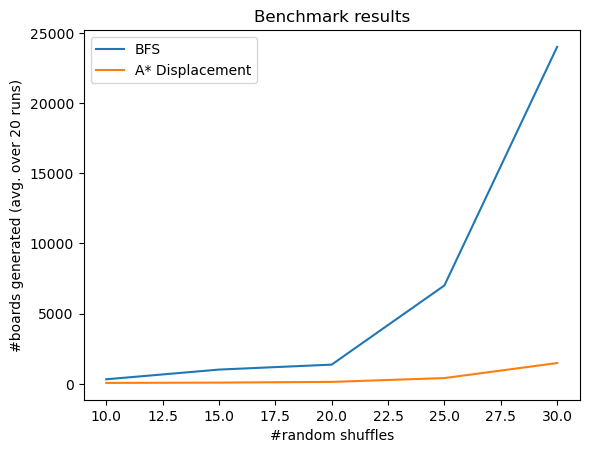

In [139]:
plot_benchmark_data(benchmark_data)